In [ ]:
import ray
ray.init()

In [145]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)

import pandas_bokeh
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

import market_preprocess as mp
import market_cluster as mc
import polygon_ds as pds
import polygon_df as pdf
import polygon_s3 as ps3
import ray_symbol_details as rsd
import utils_pickle as up

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
start_date = '2018-10-24'
end_date = '2020-11-24'
symbol = 'market'
tick_type='daily'

In [109]:
df, sym_labels, m_close, m_returns, m_log_returns, m_zs_returns, m_g_zs_returns = mp.prepare_data(start_date, end_date)

4502494 Initial rows
-1460110 all dates filter
-383980 liquidity filter
-125188 volitility filter
-24196 min $value filter
-959424 symbol details filter
1549596 Final rows 34.4 % remaining
2946 symbols included


In [142]:
# sym_stats = df.groupby('symbol').agg({'range_value_pct': ['median', 'mean'], 'dollar_total': ['median', 'mean']})

sym_stats = df.groupby('symbol')[['range_value_pct', 'dollar_total']].median()

<AxesSubplot:>

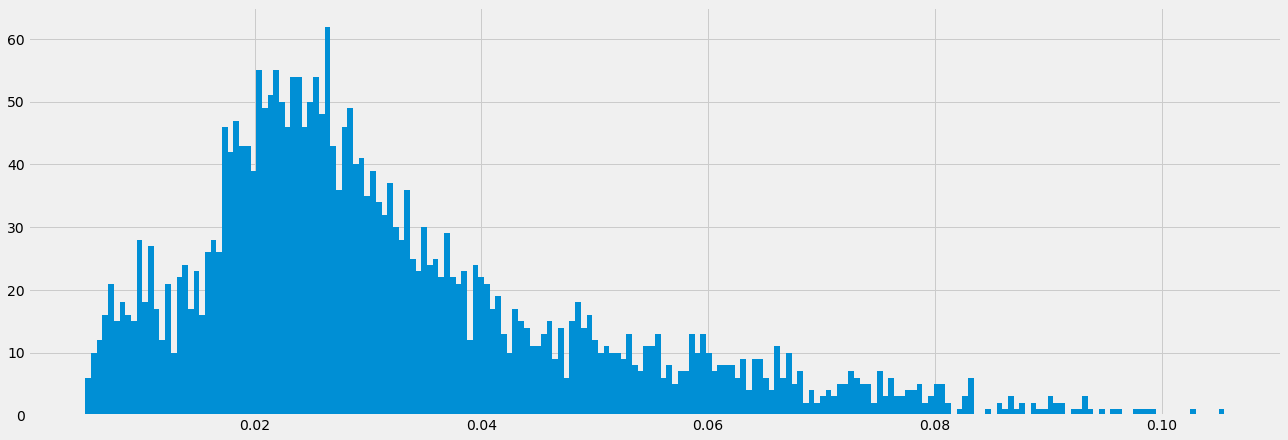

In [155]:
sym_stats.range_value_pct.hist(bins=200)

In [163]:
sym_labels.join(other=sym_stats)

,name,sector,industry,tags,similar,type,range_value_pct,dollar_total
symbol,,,,,,,,
A,Agilent Technologies Inc.,Healthcare,Medical Diagnostics & Research,"[Healthcare, Diagnostics & Research, Medical D...","[NATI, ILMN, BRKR, AME, DHR, GE, TMO, PKI, TER...",cs,0.018306,147754016.000000
AA,Alcoa Corporation,Basic Materials,Metals & Mining,"[Basic Materials, Aluminum, Metals & Mining]","[BBL, CENX, KALU, BHP, ACH]",CS,0.039895,80607904.000000
AAL,American Airlines Group Inc.,Industrials,Airlines,"[Industrials, Airlines]","[SKYW, JBLU, HA, ALGT, ALK, LUV, DAL, LTM, SAV...",CS,0.035749,298574528.000000
AAN,Aaron's Inc.,Industrials,Consulting & Outsourcing,"[Industrials, Rental & Leasing Services, Consu...","[RCII, CONN, BBY, PIR, WSM, GME]",CS,0.030655,31988214.000000
AAOI,Applied Optoelectronics Inc.,Technology,Semiconductors,"[Technology, Semiconductors]","[CSCO, FNSR, OCLR, MXL, NPTN, EMKR, VIAV, XLK]",CS,0.049582,6809254.000000
...,...,...,...,...,...,...,...,...
SWN,Southwestern Energy Company,Energy,Oil & Gas - E&P,"[Energy, Oil & Gas E&P, Oil & Gas - E&P]","[CHK, NFX, COG, OXY, MRO, NBL, EQT, HES, QEP]",CS,0.059837,50263184.000000
SWX,Southwest Gas Holdings Inc.,Utilities,Utilities - Regulated,"[Utilities, Utilities - Regulated Gas, Utiliti...","[OKE, SRE, ATO, NFG, CNP, SR, XLU]",CS,0.020195,20963344.000000
SXC,SunCoke Energy Inc.,Basic Materials,Coal,"[Basic Materials, Coal]","[CLD, SXCP, MT, SES]",CS,0.044325,3954507.250000


In [137]:
# sym_details = pdf.get_symbol_details_df(symbols=m_returns.columns.values)

sym_details = pd.read_feather('data/sym_details.feather', columns=['symbol', 'name', 'sector', 'industry', 'tags', 'similar', 'type'])

sym_labels = sym_details[(sym_details.sector!='') & (sym_details.type.str.upper()=='CS')].set_index('symbol')

In [ ]:
remaining_symbols = set(m_g_zs_returns.columns.values) - set(sym_details.symbol.values)

In [ ]:
# df.reset_index().to_feather('market_daily.feather')

# ps3.put_df_to_s3(df.reset_index(), tick_type='market_daily', other='returns')

In [ ]:
corex300 = up.pickle_load('data/corex300.pkl')

# X = df.reset_index(drop=True)
# corex, full_df = mc.corex_fit(X, n_hidden=200)

# up.pickle_dump((corex, full_df), file_name='corex200.pkl')

# gsutil copy /Users/bobcolner/QuantClarity/pandas-polygon/corex200.pkl gs://emerald-skill-datascience/

In [ ]:
import corex_gaussianize as g

norm = g.Gaussianize(strategy='lambert')

gld = df[df.symbol=='GLD']

norm.fit(df[df.symbol=='GLD'].close)

In [ ]:
import h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator
h2o.init()

# Import the USArrests dataset into H2O:
arrestsH2O = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/pca_test/USArrests.csv")

# Split the dataset into a train and valid set:
train, valid = arrestsH2O.split_frame(ratios=[.8], seed=1234)

# Build and train the model:
glrm_model = H2OGeneralizedLowRankEstimator(k=4,
                                            loss="Huber",
                                            # loss_by_col={'cat_var': 'Categorical'},
                                            regularization_x="OneSparse", # None (default), Quadratic, L2, L1, NonNegative, OneSparse, UnitOneSparse, Simplex.
                                            regularization_y="OneSparse",
                                            gamma_x=0.5,
                                            gamma_y=0.5,
                                            max_iterations=1000,
                                            recover_svd=True,
                                            init="PlusPlus",
                                            transform="standardize",
                                           )
glrm_model.train(training_frame=train)

In [ ]:
### market clustering

# %time df = read_market_daily(result_path)
mdf = pd.read_parquet('data/old/mdf.parquet')

%time npdf, sharpe_ratios = mc.normalize_market_df(mdf)

# %time npdf_resid = colwise_linreg(npdf)
npdf_resid = pd.read_parquet('data/old/npdf_resid.parquet')

# %time par_cor_mat = npdf_resid.corr()
resid_par_cor_mat = pd.read_parquet('data/old/partial_cor_mat.parquet')

details_df = pd.read_parquet('data/old/details_df.parquet')

# cluster_lables = cluster_sim_matrix(similarity=resid_par_cor_mat.abs())
cluster_lables = pd.read_parquet('data/old/cluster_lables.parquet')

# symbol_meta = join_symbol_data(details_df, cluster_lables, sharpe_ratios, mdf)
symbol_meta = pd.read_parquet('data/old/symbol_meta.parquet')

# cluster_coheasion = mc.get_cluster_coheasion(sim_df=resid_par_cor_mat.abs(), symbol_meta=symbol_meta, cluster_col='cluster_n200')

In [ ]:
symbol_meta['liquidy_rank'] = symbol_meta.groupby('cluster_n200')['daily_avg_dollar_volume'].rank(method='first')

symbol_meta = symbol_meta.sort_values(['cluster_n200', 'liquidy_rank']).reset_index()

by_cluster = symbol_meta.groupby('cluster_n200')
result = []
for cluster, frame in by_cluster:
    counts = dict(frame['sector'].value_counts())
    counts.pop('', None)  # drop symbols w/o sector/industry info
    result.append(counts)

In [ ]:
cluster_sec = pd.DataFrame(result)    
cluster_sec = cluster_sec.drop(columns=['Finance'])
cluster_sec_pct = cluster_sec.apply(lambda x: 100 * x / float(x.sum()), axis=1)

cluster_sec_pct.style.background_gradient(cmap='coolwarm', axis=0)

# n += 1
n = 61
print(n)
symbol_meta[symbol_meta.cluster_n200 == n].sector.value_counts()

sym_clust = symbol_meta[symbol_meta.cluster_n200 == n]
sym_clust